# Imports and Colab Mount

In [2]:
!pip install tensorflow-addons -qq

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [3]:
import datetime
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
from math import sqrt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, GRU, SimpleRNN, Input, LSTM, Dense, Bidirectional, Concatenate, Reshape, Lambda, Bidirectional
from keras.models import Model, Sequential
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import seaborn as sns

from numpy.random import seed
#from tensorflow import set_random_seed

%matplotlib inline

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
utils.set_random_seed(42)

# Load Data

In [6]:
hourly = pd.read_excel("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/BASERECIFEhorario.xlsx", index_col=0, parse_dates=[["Data", "HORA (UTC)"]])
hourly = hourly[ ['Velocidade'] + [ col for col in hourly.columns if col != 'Velocidade' ] ]
quarto = int(hourly["Velocidade"].shape[0]/4)

resid_train = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/recifehora_resid_train.csv").drop("Unnamed: 0", axis=1)
resid_test = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/recifehora_resid_test2.csv").drop("Unnamed: 0", axis=1)

sarima_pred = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/recifehora_prediction.csv").drop("Unnamed: 0", axis=1)
sarima_pred2 = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/recifehora_prediction2.csv").drop("Unnamed: 0", axis=1)

#hourly["Velocidade"] = pd.concat([resid_train, resid_test]).reset_index()["0"].values
resid_series = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/recifehora_resid_series.csv").drop("Unnamed: 0", axis=1)

train_h = hourly.iloc[:quarto*2]
valid_h = hourly.iloc[quarto*2:quarto*3]
test_h = hourly.iloc[quarto*3:]

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
def make_data(data, timestep, resid_check=False):
  values = data.values
  values = values.astype('float32')
  #scaler = MinMaxScaler(feature_range=(0, 1))
  #scaled = scaler.fit_transform(values)
  
  timestep = timestep
  n_features = data.shape[1]
  n_obs = timestep * n_features
  reframed = series_to_supervised(values, timestep, 1)
  reframed = reframed.iloc[: , :1-n_features]

  values = reframed.values
  indice1 = train_h.shape[0]
  indice2 = valid_h.shape[0]

  train = values[:indice1, :]
  valid = values[indice1:indice1+indice2, :]
  test = values[indice1+indice2:, :]

  train_X, train_y = train[:, :-1], train[:, -1]
  valid_X, valid_y = valid[:, :-1], valid[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  if (resid_check==True):
    train_y = resid_train.values[:quarto*2]
    valid_y = resid_train.values[quarto*2:]

  scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_X)
  train_X = scaler.transform(train_X)
  valid_X = scaler.transform(valid_X)
  test_X = scaler.transform(test_X)

  scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_y.reshape(-1,1))
  train_y = scaler_y.transform(train_y.reshape(-1,1))
  valid_y = scaler_y.transform(valid_y.reshape(-1,1))
  test_y = scaler_y.transform(test_y.reshape(-1,1))

  train_X = train_X.reshape((train_X.shape[0], timestep, n_features))
  valid_X = valid_X.reshape((valid_X.shape[0], timestep, n_features))
  test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
  return train_X, train_y, valid_X, valid_y, test_X, test_y

In [9]:
def make_data2(data, timestep, resid_check=False):
  values = data.values
  values = values.astype('float32')
  #scaler = MinMaxScaler(feature_range=(0, 1))
  #scaled = scaler.fit_transform(values)
  
  timestep = timestep
  n_features = data.shape[1]
  n_obs = timestep * n_features
  reframed = series_to_supervised(values, timestep, 1)
  reframed = reframed.iloc[: , :1-n_features]

  values = reframed.values
  indice1 = train_h.shape[0]
  indice2 = valid_h.shape[0]

  train = values[:indice1, :]
  valid = values[indice1:indice1+indice2, :]
  test = values[indice1+indice2:, :]

  train_X, train_y = train[:, :-1], train[:, -1]
  valid_X, valid_y = valid[:, :-1], valid[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  if (resid_check==True):
    train_y = resid_train.values[:quarto*2]
    valid_y = resid_train.values[quarto*2:]

  scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_X)
  train_X = scaler.transform(train_X)
  valid_X = scaler.transform(valid_X)
  test_X = scaler.transform(test_X)

  scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_y.reshape(-1,1))
  train_y = scaler_y.transform(train_y.reshape(-1,1))
  valid_y = scaler_y.transform(valid_y.reshape(-1,1))
  test_y = scaler_y.transform(test_y.reshape(-1,1))

  train_X = train_X.reshape((train_X.shape[0], timestep, n_features))
  valid_X = valid_X.reshape((valid_X.shape[0], timestep, n_features))
  test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
  return train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y

In [10]:
def make_data3(df, timestep, resid_check=False, resid=False, univariate=False):

  data = df.copy()

  if resid==True:
    data['Velocidade'] = resid_series.values

  if univariate==True:
    values = data["Velocidade"].values
    values = values.astype('float32')
    values = values.reshape(-1, 1)

    timestep = timestep
    n_features = 1
    n_obs = timestep * n_features
    reframed = series_to_supervised(values, timestep, 1)

  else:
    values = data.values
    values = values.astype('float32')
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled = scaler.fit_transform(values)
    
    timestep = timestep
    n_features = data.shape[1]
    n_obs = timestep * n_features
    reframed = series_to_supervised(values, timestep, 1)
    reframed = reframed.iloc[: , :1-n_features]

  values = reframed.values
  indice1 = train_h.shape[0]
  indice2 = valid_h.shape[0]

  train = values[:indice1, :]
  valid = values[indice1:indice1+indice2, :]
  test = values[indice1+indice2:, :]

  train_X, train_y = train[:, :-1], train[:, -1]
  valid_X, valid_y = valid[:, :-1], valid[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  if (resid_check==True):
    train_y = resid_series.values[timestep:(quarto*2)+timestep]
    valid_y = resid_series.values[(quarto*2)+timestep:(quarto*3)+timestep]
    #test_y = resid_series.values[(quarto*3)+timestep:]
  if (resid==True):
    test_y = df['Velocidade'].values[(quarto*3)+timestep:]

  scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_X)
  train_X = scaler.transform(train_X)
  valid_X = scaler.transform(valid_X)
  test_X = scaler.transform(test_X)

  scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_y.reshape(-1,1))
  train_y = scaler_y.transform(train_y.reshape(-1,1))
  valid_y = scaler_y.transform(valid_y.reshape(-1,1))
  test_y = scaler_y.transform(test_y.reshape(-1,1))

  train_X = train_X.reshape((train_X.shape[0], timestep, n_features))
  valid_X = valid_X.reshape((valid_X.shape[0], timestep, n_features))
  test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
  return train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y

# Test

# RNN

In [ ]:
rmse_list = []
mae_list = []
mape_list = []

timestep=4
layers=2
num_units=256
dropout=0
lr=0.01
batch_size=256

utils.set_random_seed(1)
for z in tqdm(range(10)):
  train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y = make_data2(hourly, timestep, resid_check=True)
  model = Sequential()

  if layers > 1:
    model.add(SimpleRNN(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout, return_sequences=True))

    for i in range(layers-2):
      model.add(SimpleRNN(units = num_units, dropout=dropout, return_sequences=True))

    model.add(SimpleRNN(units = num_units, dropout=dropout))

  else:
    model.add(SimpleRNN(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))

  model.add(Dense(units = 1))

  model.compile(
    loss="mse",
    optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr*1e-3)
  )

  model.fit(train_X, train_y, batch_size=batch_size,
          epochs=200, verbose=0, shuffle=False,
          validation_data=(valid_X, valid_y),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
  
  # make a prediction
  yhat = model.predict(test_X)
  yhat_inv = scaler_y.inverse_transform(yhat)
  resid_sum = (yhat_inv+sarima_pred.values[timestep:])

  rmse_list.append(sqrt(mean_squared_error(resid_sum, scaler_y.inverse_transform(test_y))))
  mae_list.append(mean_absolute_error(resid_sum, scaler_y.inverse_transform(test_y)))
  mape_list.append(mean_absolute_percentage_error(resid_sum, scaler_y.inverse_transform(test_y)))
  print()
print(f"RNN LIST OF RMSE: {rmse_list}")
print(f'RNN RMSE:  {sum(rmse_list)/len(rmse_list)}')

print(f"RNN LIST OF MAE: {mae_list}")
print(f'RNN MAE:  {sum(mae_list)/len(mae_list)}')

print(f"RNN LIST OF MAPE: {mape_list}")
print(f'RNN MAPE:  {sum(mape_list)/len(mape_list)}')

 10%|█         | 1/10 [00:04<00:42,  4.77s/it]

 20%|██        | 2/10 [00:08<00:32,  4.04s/it]

 30%|███       | 3/10 [00:20<00:55,  7.99s/it]

 40%|████      | 4/10 [00:27<00:45,  7.60s/it]

 50%|█████     | 5/10 [00:35<00:36,  7.40s/it]

 60%|██████    | 6/10 [00:41<00:28,  7.07s/it]

 70%|███████   | 7/10 [00:48<00:21,  7.04s/it]

 80%|████████  | 8/10 [00:52<00:12,  6.22s/it]

 90%|█████████ | 9/10 [00:58<00:06,  6.06s/it]

100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


RNN LIST OF RMSE: [0.8063664064141859, 0.8216324192873096, 0.8671696459453855, 1.124511050385947, 0.8434827302944158, 0.8266150878654825, 0.8253931303973316, 1.0809771902827088, 0.838264082270074, 0.8171026206118492]
RNN RMSE:  0.8851514363754689
RNN LIST OF MAE: [0.6549063897522693, 0.6697328919641764, 0.6737204057224204, 0.7419734550320285, 0.6992099945143404, 0.6743679091292784, 0.6759696270736527, 0.8775327141250743, 0.6922120537145183, 0.6624290864263989]
RNN MAE:  0.7022054527454158
RNN LIST OF MAPE: [0.22716584577230414, 0.2281639288211553, 0.6283112672299992, 0.27587515887436576, 0.254993518475557, 0.22951475477473798, 0.23229200806630027, 0.5574201596639327, 0.26961773503771225, 0.2294306500333812]
RNN MAPE:  0.3132785026749446


# LSTM

In [ ]:
rmse_list = []
mae_list = []
mape_list = []

timestep=3
layers=4
num_units=128
dropout=0.3
lr=0.01
batch_size=128

utils.set_random_seed(1)
for z in tqdm(range(10)):
  train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y = make_data2(hourly, timestep, resid_check=True)
  model = Sequential()

  if layers > 1:
    model.add(LSTM(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout, return_sequences=True))

    for i in range(layers-2):
      model.add(LSTM(units = num_units, dropout=dropout, return_sequences=True))

    model.add(LSTM(units = num_units, dropout=dropout))

  else:
    model.add(LSTM(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))

  model.add(Dense(units = 1))

  model.compile(
    loss="mse",
    optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr*1e-4)
  )

  model.fit(train_X, train_y, batch_size=batch_size,
          epochs=200, verbose=0, shuffle=False,
          validation_data=(valid_X, valid_y),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
  
  # make a prediction
  yhat = model.predict(test_X)
  yhat_inv = scaler_y.inverse_transform(yhat)
  resid_sum = (yhat_inv+sarima_pred.values[timestep:])

  rmse_list.append(sqrt(mean_squared_error(resid_sum, scaler_y.inverse_transform(test_y))))
  mae_list.append(mean_absolute_error(resid_sum, scaler_y.inverse_transform(test_y)))
  mape_list.append(mean_absolute_percentage_error(resid_sum, scaler_y.inverse_transform(test_y)))
  print()
print(f"LSTM LIST OF RMSE: {rmse_list}")
print(f'LSTM RMSE:  {sum(rmse_list)/len(rmse_list)}')

print(f"LSTM LIST OF MAE: {mae_list}")
print(f'LSTM MAE:  {sum(mae_list)/len(mae_list)}')

print(f"LSTM LIST OF MAPE: {mape_list}")
print(f'LSTM MAPE:  {sum(mape_list)/len(mape_list)}')

 10%|█         | 1/10 [00:16<02:24, 16.06s/it]

 20%|██        | 2/10 [00:36<02:28, 18.61s/it]

 30%|███       | 3/10 [01:06<02:47, 23.99s/it]

 40%|████      | 4/10 [01:26<02:13, 22.23s/it]

 50%|█████     | 5/10 [01:41<01:37, 19.53s/it]

 60%|██████    | 6/10 [01:55<01:11, 17.80s/it]

 70%|███████   | 7/10 [02:13<00:53, 17.78s/it]

 80%|████████  | 8/10 [02:28<00:33, 16.83s/it]

 90%|█████████ | 9/10 [02:42<00:16, 16.15s/it]

100%|██████████| 10/10 [02:57<00:00, 17.79s/it]


LSTM LIST OF RMSE: [0.8234780885529276, 0.7760036849439178, 0.767119985504319, 0.7733674041670524, 0.8152253326627426, 0.765202864446323, 0.7547880617656949, 0.7860515491419332, 0.8082372361332172, 0.7661052751426498]
LSTM RMSE:  0.7835579482460777
LSTM LIST OF MAE: [0.67498131121878, 0.630377596741592, 0.6237495100264401, 0.6242722995146968, 0.6639893812886107, 0.6240727079764242, 0.6049350947147027, 0.6460789521438138, 0.6637459854063096, 0.6254357197915075]
LSTM MAE:  0.6381638558822877
LSTM LIST OF MAPE: [0.23226231409877296, 0.22537917633115065, 0.22858305841137702, 0.22600584930378165, 0.2284013724892489, 0.24506193129269147, 0.22910136149884414, 0.23830766274085105, 0.23435664800306572, 0.24179115294000267]
LSTM MAPE:  0.2329250527109786


# GRU

In [ ]:
rmse_list = []
mae_list = []
mape_list = []

timestep=2
layers=8
num_units=128
dropout=0.3
lr=0.01
batch_size=64

utils.set_random_seed(1)

for z in tqdm(range(10)):
  train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y = make_data2(hourly, timestep, resid_check=True)
  model = Sequential()

  if layers > 1:
    model.add(GRU(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout, return_sequences=True))

    for i in range(layers-2):
      model.add(GRU(units = num_units, dropout=dropout, return_sequences=True))

    model.add(GRU(units = num_units, dropout=dropout))

  else:
    model.add(GRU(units = num_units, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))

  model.add(Dense(units = 1))

  model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=lr)
  )

  model.fit(train_X, train_y, batch_size=batch_size,
          epochs=200, verbose=0, shuffle=False,
          validation_data=(valid_X, valid_y),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
  
  # make a prediction
  yhat = model.predict(test_X)
  yhat_inv = scaler_y.inverse_transform(yhat)
  resid_sum = (yhat_inv+sarima_pred.values[timestep:])

  rmse_list.append(sqrt(mean_squared_error(resid_sum, scaler_y.inverse_transform(test_y))))
  mae_list.append(mean_absolute_error(resid_sum, scaler_y.inverse_transform(test_y)))
  mape_list.append(mean_absolute_percentage_error(resid_sum, scaler_y.inverse_transform(test_y)))
  print()
print(f"GRU LIST OF RMSE: {rmse_list}")
print(f'GRU RMSE:  {sum(rmse_list)/len(rmse_list)}')

print(f"GRU LIST OF MAE: {mae_list}")
print(f'GRU MAE:  {sum(mae_list)/len(mae_list)}')

print(f"GRU LIST OF MAPE: {mape_list}")
print(f'GRU MAPE:  {sum(mape_list)/len(mape_list)}')

 10%|█         | 1/10 [00:43<06:34, 43.81s/it]

 20%|██        | 2/10 [01:16<05:00, 37.54s/it]

 30%|███       | 3/10 [01:47<04:00, 34.37s/it]

 40%|████      | 4/10 [02:21<03:24, 34.05s/it]

 50%|█████     | 5/10 [02:53<02:46, 33.38s/it]

 60%|██████    | 6/10 [03:22<02:08, 32.05s/it]

 70%|███████   | 7/10 [04:01<01:42, 34.33s/it]

 80%|████████  | 8/10 [04:30<01:05, 32.58s/it]

 90%|█████████ | 9/10 [04:58<00:31, 31.06s/it]

100%|██████████| 10/10 [05:37<00:00, 33.77s/it]


GRU LIST OF RMSE: [0.7731489834406177, 0.7746607558774954, 0.7682749327965753, 0.7649163959472617, 0.7633798414023338, 0.810972239432988, 0.7794747700841969, 0.8171626009150863, 0.8257794028401162, 0.7582083618556253]
GRU RMSE:  0.7835978284592297
GRU LIST OF MAE: [0.627929120945189, 0.6271748879151536, 0.6206422463514215, 0.6190184011424632, 0.6198485323198276, 0.6605246050402445, 0.6355739359728173, 0.6666170093266266, 0.6840237434355246, 0.6120322383343627]
GRU MAE:  0.6373384720783631
GRU LIST OF MAPE: [0.23349198350221165, 0.23152677721108303, 0.23383943863698783, 0.23506820349672902, 0.23453537886047532, 0.2350630883234974, 0.23306163998332916, 0.23491757946982314, 0.2384210295196778, 0.23317176002581982]
GRU MAPE:  0.23430968790296341


# Transformer

In [15]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = keras.Sequential( [layers.Dense(ff_dim, activation = "gelu"), layers.Dense(feat_dim),] )
        self.layernorm1 = layers.BatchNormalization()
        self.layernorm2 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim
        self.feat_dim = feat_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):

        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'feat_dim': self.feat_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

In [16]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size = 1):
        super(Time2Vec, self).__init__(trainable = True, name = 'Time2VecLayer')
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name = 'wb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        self.bb = self.add_weight(name = 'bb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        # periodic
        self.wa = self.add_weight(name = 'wa', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        self.ba = self.add_weight(name = 'ba', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)
        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))

    def get_config(self):

        config = super().get_config()
        config.update({
            'kernel_size': self.k,
        })
        return config

In [17]:
EPOCHS = 50
N_HEADS = 8
N_FOLDS = 10
FF_DIM = 256
N_BLOCKS = 6
EMBED_DIM = 64
BATCH_SIZE = 16
WINDOW_SIZE = 65
DROPUT_RATE = 0.0
TIME_2_VEC_DIM = 3
TRAIN_MODEL = True
SKIP_CONNECTION_STRENGTH = 0.9

In [20]:
rmse_list = []
mae_list = []
mape_list = []

batch_size=32
lr=0.001
N_HEADS = 8
FF_DIM = 128
N_BLOCKS = 8
EMBED_DIM = 64
DROPUT_RATE = 0.3
time2vec_dim = 2
timestep = 7


for z in tqdm(range(1)):
  utils.set_random_seed(16)

  train_X, train_y, valid_X, valid_y, test_X, test_y, scaler, scaler_y = make_data3(hourly, timestep, resid_check=True, resid=False, univariate=False)


  input_shape = train_X.shape[1:]
  inp = Input(input_shape)
  x = inp

  time_embedding = keras.layers.TimeDistributed(Time2Vec(time2vec_dim - 1))(x)
  x = Concatenate(axis = -1)([x, time_embedding])
  x = layers.LayerNormalization(epsilon = 1e-6)(x)

  for k in range(N_BLOCKS):
    x_old = x
    transformer_block = TransformerBlock(EMBED_DIM, input_shape[-1] + ( input_shape[-1] * time2vec_dim), N_HEADS, FF_DIM, DROPUT_RATE)
    x = transformer_block(x)
    x = ((1.0 - SKIP_CONNECTION_STRENGTH) * x) + (SKIP_CONNECTION_STRENGTH * x_old)

  x = layers.Flatten()(x)

  x = layers.Dense(128, activation = "selu")(x)
  x = layers.Dropout(DROPUT_RATE)(x)
  x = Dense(1, activation = 'linear')(x)

  out = x
  model = Model(inp, out)

#   radam = tfa.optimizers.RectifiedAdam(
#     lr=1e-3,
#     total_steps=10000,
#     warmup_proportion=0.1,
#     min_lr=1e-6,
# )

#   ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)


  model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=lr)
              )

  model.fit(train_X, train_y, batch_size=batch_size,
          epochs=200, verbose=0, shuffle=False,
          validation_data=(valid_X, valid_y),
          callbacks=[EarlyStopping(patience=20, restore_best_weights=True)]
          )
  
  # make a prediction
  yhat = model.predict(test_X)
  yhat_inv = scaler_y.inverse_transform(yhat)
  resid_sum = (yhat_inv+sarima_pred2.values[timestep:]).clip(min=0)

  rmse_list.append(sqrt(mean_squared_error(resid_sum, scaler_y.inverse_transform(test_y))))
  mae_list.append(mean_absolute_error(resid_sum, scaler_y.inverse_transform(test_y)))
  mape_list.append(mean_absolute_percentage_error(resid_sum, scaler_y.inverse_transform(test_y)))
  print()
print(f"Transformer LIST OF RMSE: {rmse_list}")
print(f'Transformer RMSE:  {sum(rmse_list)/len(rmse_list)}')

print(f"Transformer LIST OF MAE: {mae_list}")
print(f'Transformer MAE:  {sum(mae_list)/len(mae_list)}')

print(f"Transformer LIST OF MAPE: {mape_list}")
print(f'Transformer MAPE:  {sum(mape_list)/len(mape_list)}')

100%|██████████| 1/1 [01:48<00:00, 108.02s/it]


Transformer LIST OF RMSE: [0.6281278148142436]
Transformer RMSE:  0.6281278148142436
Transformer LIST OF MAE: [0.46218657965363763]
Transformer MAE:  0.46218657965363763
Transformer LIST OF MAPE: [0.19288747366109754]
Transformer MAPE:  0.19288747366109754


In [ ]:
sarima_pred3 = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/recifehora_prediction_bad.csv").drop("Unnamed: 0", axis=1)

In [ ]:
sarima_pred3

,0
0,2.990569
1,2.997352
2,2.660366
3,2.885126
4,2.894548
...,...
181,2.752886
182,2.752886
183,2.752886
184,2.752887


In [21]:
pd.Series(resid_sum[:,0]).to_csv("/content/drive/MyDrive/Hybrid Transformer/Results/recife.csv")
pd.Series(scaler_y.inverse_transform(test_y)[:,0]).to_csv("/content/drive/MyDrive/Hybrid Transformer/Results/recife_test.csv")
#scaler_y.inverse_transform(test_y)

In [23]:
resid_sum = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Results/recife.csv").drop("Unnamed: 0", axis=1)["0"].values
test_y = pd.read_csv("/content/drive/MyDrive/Hybrid Transformer/Results/recife_test.csv").drop("Unnamed: 0", axis=1)["0"].values

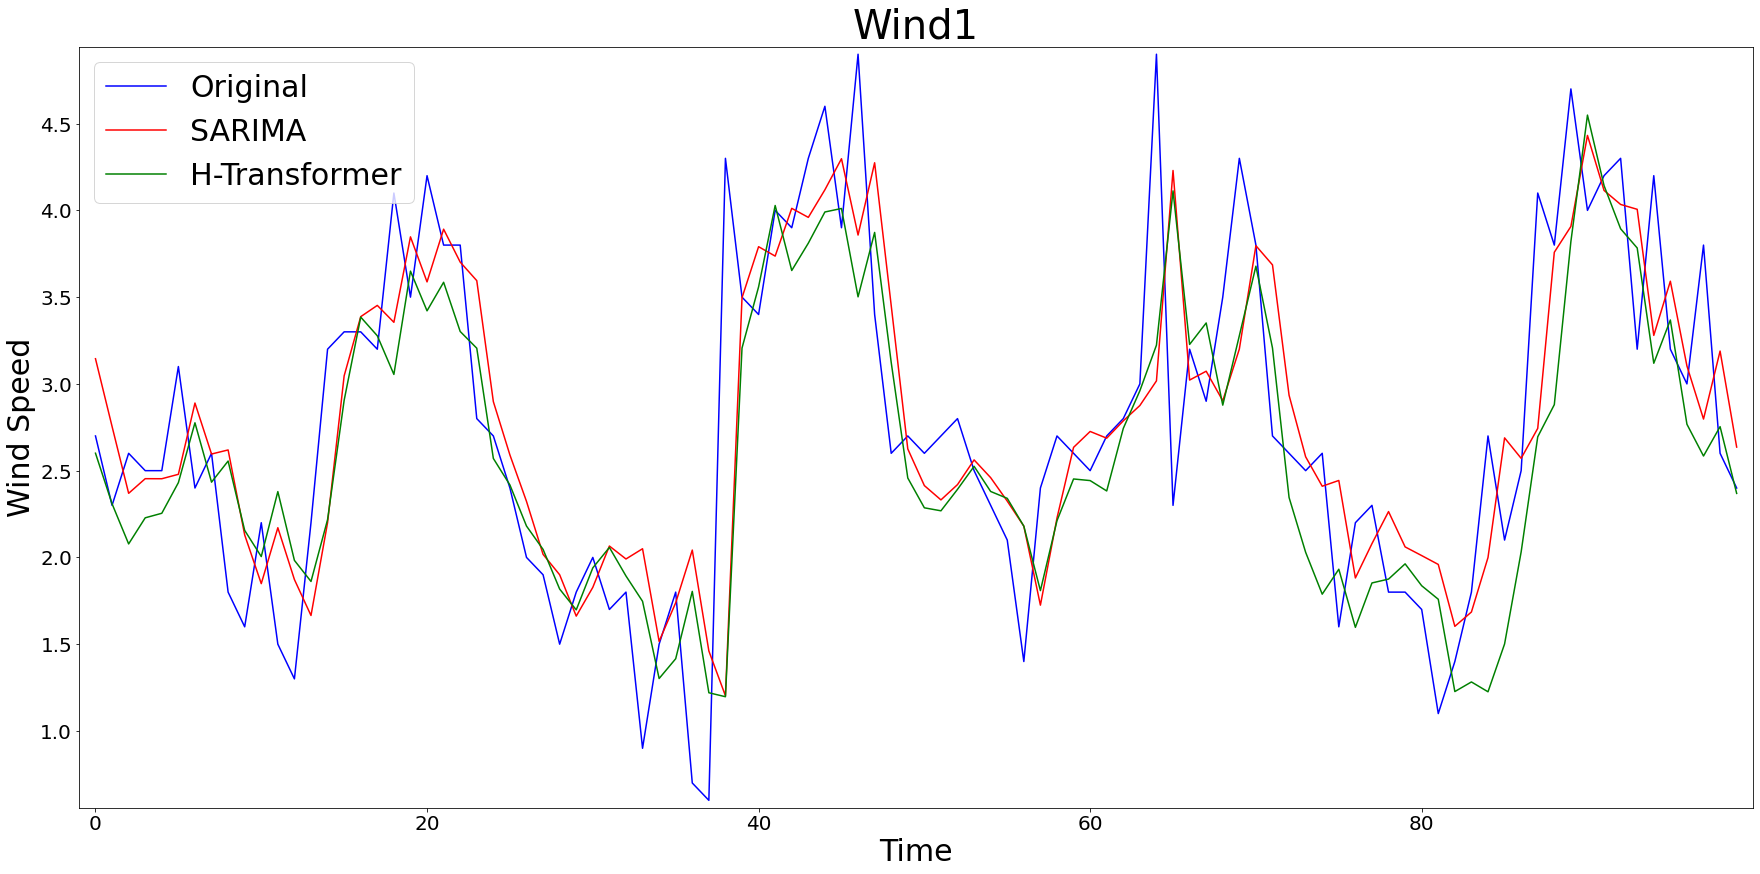

In [29]:
size = range(sarima_pred.values[-100:].shape[0])
plt.figure(figsize=(30, 14))
plt.plot(size, test_y[-100:], 'b', label='Original')
plt.plot(size, sarima_pred2.values[-100:], 'r', label='SARIMA')
plt.plot(size, (resid_sum.clip(min=0)[-100:]), 'g', label='H-Transformer')


plt.title("Wind1", fontdict = {'fontsize' : 40})
plt.legend(fontsize=30, loc='upper left')
plt.ylabel('Wind Speed', fontdict = {'fontsize' : 30})
plt.xlabel('Time', fontdict = {'fontsize' : 30})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.margins(x=0.01, y=0.01)

plt.show()